In [1]:
import numpy as np
import matplotlib.pylab as plt 
from numpyro.diagnostics import summary
import pandas as pd
from utils.helpers import pickle_load

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 15

settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3, 'smooth_scale_1D':0.3}
color1 = '#50C878' #'#B5CA8D'
color3 = '#222E50'
alpha = 0.5
palefactor = 0.9
linewidth = 2 
contours = [0.68,0.95]

In [2]:
labels = [r'$\sigma_{8}$', r'$\Omega_{c}$', r'$\Omega_{b}$', r'$h$', r'$n_{s}$',
          r'$m_{1}$', r'$m_{2}$', r'$m_{3}$', r'$m_{4}$', 
          r'$\delta z_{1}^{(s)}$', r'$\delta z_{2}^{(s)}$', r'$\delta z_{3}^{(s)}$', r'$\delta z_{4}^{(s)}$',
          r'$A_{IA}$', r'$\eta$', r'$b_{1}$', r'$b_{2}$', r'$b_{3}$', r'$b_{4}$', r'$b_{5}$',
         r'$\delta z_{1}^{(g)}$', r'$\delta z_{2}^{(g)}$', r'$\delta z_{3}^{(g)}$', r'$\delta z_{4}^{(g)}$', r'$\delta z_{5}^{(g)}$']

In [3]:
labels_cosmo = labels[0:5]
labels_multiplicative = labels[5:9]
labels_shift_shear = labels[9:13]
labels_intrinsic = labels[13:15]
labels_bias = labels[15:20]
labels_shift_galaxy = labels[20:]

In [4]:
KEYS = ['sigma8', 'Omegac', 'Omegab', 'hubble', 'ns',
        'm1', 'm2', 'm3', 'm4',
        'dz_wl_1', 'dz_wl_2', 'dz_wl_3', 'dz_wl_4',
        'a_ia', 'eta',
        'b1', 'b2', 'b3', 'b4', 'b5', 
        'dz_gc_1', 'dz_gc_2', 'dz_gc_3', 'dz_gc_4', 'dz_gc_5']

# Compare Diagnostics

In [5]:
def nuts_stats(engine = 'jaxcosmo'):

    sampler = pickle_load('samples', f'{engine}_nuts_small_ss_high_td')
    
    num_steps = sampler.get_extra_fields(group_by_chain=True)['num_steps'].sum(1).sum(0).item()

    print(f'Number of evaluations for NUTS is: {num_steps}')

    samples = sampler.get_samples(group_by_chain=True)

    record = []
    for key in KEYS:
        summary_stats = summary(samples[key])
        summary_stats[key] = summary_stats.pop('Param:0')
        record.append(summary_stats)

    record_df = []
    for i in range(len(record)):
        record_df.append(pd.DataFrame(record[i]).round(3).loc[['r_hat', 'n_eff', 'mean', 'std']])

    record_df = pd.concat(record_df, axis = 1).T
    record_df['scaled_n_eff'] = record_df['n_eff'] / num_steps
    return record_df
    
def emcee_stats(engine = 'jaxcosmo'):

    test_1 = pickle_load('samples', f'{engine}_emcee_1')
    test_2 = pickle_load('samples', f'{engine}_emcee_2')

    nevals = test_1.flatchain.shape[0] + test_2.flatchain.shape[0]

    # this will generate 15 000 samples, similar to what we have for NUTS
    samples_1 = test_1.get_chain(discard = 1000, thin = 30, flat = True) # test_1.flatchain
    samples_2 = test_2.get_chain(discard = 1000, thin = 30, flat = True) # test_2.flatchain

    record = []
    for i, key in enumerate(KEYS):
        testsamples = np.vstack(([samples_1[:,i], samples_2[:,i]]))
        summary_stats = summary(testsamples)
        summary_stats[key] = summary_stats.pop('Param:0')
        record.append(summary_stats)

    record_df = []
    for i in range(len(record)):
        record_df.append(pd.DataFrame(record[i]).round(3).loc[['r_hat', 'n_eff', 'mean', 'std']])

    record_df = pd.concat(record_df, axis = 1).T
    record_df['scaled_n_eff'] = record_df['n_eff'] / nevals
    return record_df

In [14]:
statistics_nuts = nuts_stats('jaxcosmo')
statistics_emcee = emcee_stats('jaxcosmo')

Number of evaluations for NUTS is: 443757


In [15]:
statistics_emcee

,r_hat,n_eff,mean,std,scaled_n_eff
sigma8,1.006,23122.479,0.830,0.063,0.023122
Omegac,1.006,24662.874,0.228,0.025,0.024663
Omegab,1.003,27730.299,0.045,0.007,0.027730
hubble,1.005,26988.877,0.712,0.050,0.026989
ns,1.000,24831.297,0.961,0.056,0.024831
m1,1.002,27025.156,0.013,0.023,0.027025
m2,1.001,20029.921,0.011,0.023,0.020030
m3,1.000,29542.965,0.019,0.022,0.029543
m4,1.000,29991.511,0.007,0.022,0.029992
dz_wl_1,1.001,28360.697,-0.002,0.015,0.028361


In [16]:
statistics_nuts

,r_hat,n_eff,mean,std,scaled_n_eff
sigma8,1.0,5089.511,0.828,0.063,0.011469
Omegac,1.0,7251.647,0.229,0.026,0.016341
Omegab,1.0,16921.667,0.045,0.007,0.038133
hubble,1.0,13851.484,0.711,0.050,0.031214
ns,1.0,10428.335,0.958,0.056,0.023500
m1,1.0,28454.325,0.012,0.022,0.064121
m2,1.0,27208.892,0.011,0.023,0.061315
m3,1.0,25078.724,0.019,0.022,0.056515
m4,1.0,23255.399,0.008,0.022,0.052406
dz_wl_1,1.0,26754.637,-0.002,0.015,0.060291


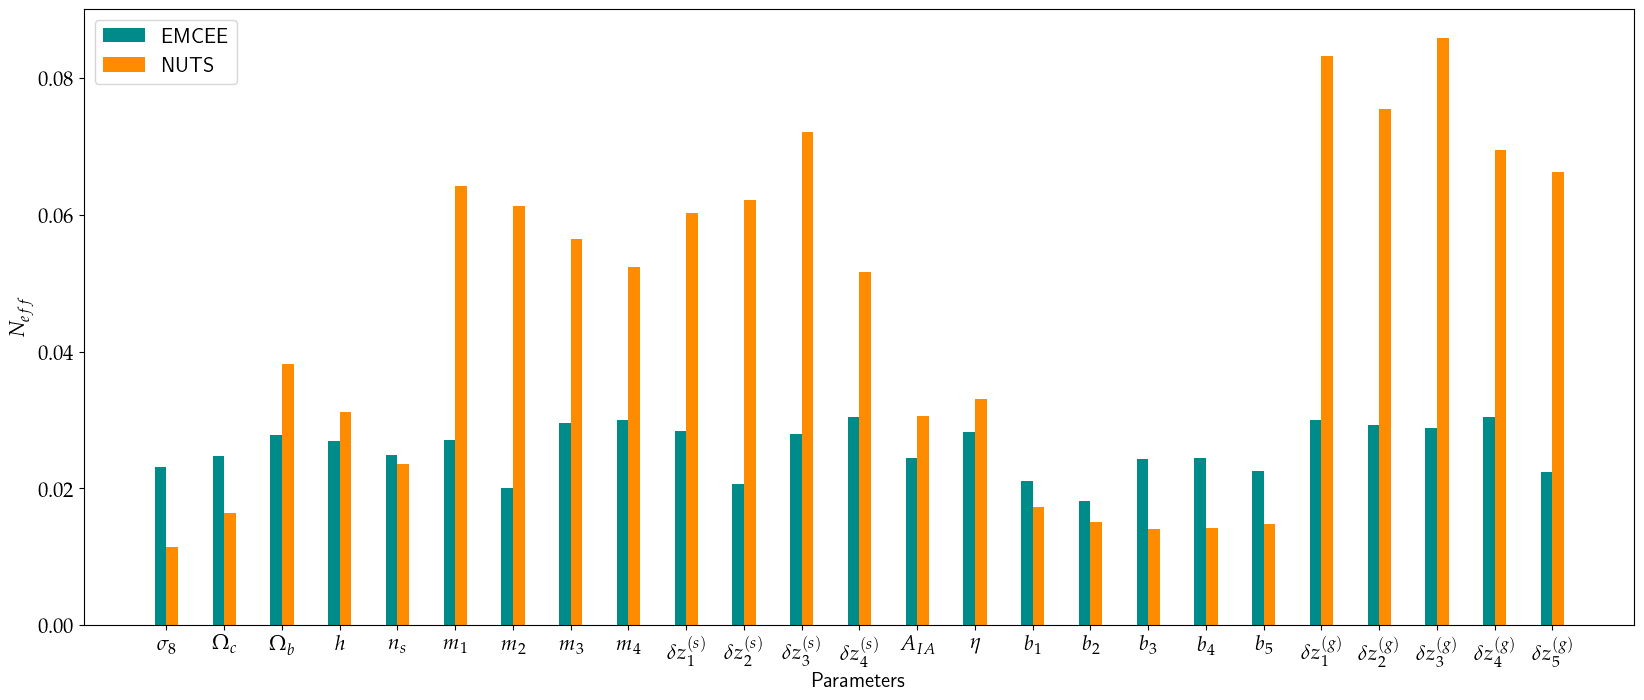

In [17]:
index = np.arange(statistics_nuts.shape[0])
bar_width = 0.20

fig, ax = plt.subplots(figsize=(20,8))
emcee_column = ax.bar(index, statistics_emcee['scaled_n_eff'], bar_width, label="EMCEE", color = 'darkcyan')
nuts_column = ax.bar(index+bar_width, statistics_nuts['scaled_n_eff'], bar_width, label="NUTS", color = 'darkorange')
ax.set_xlabel('Parameters', fontsize = fontSize)
ax.set_ylabel(r'$N_{eff}$', fontsize = fontSize)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(labels)
ax.legend(loc = 'upper left',prop={'family':'sans-serif', 'size':15})
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
# plt.savefig('plots/eff_nuts_emcee_eh.pdf', bbox_inches = 'tight')
plt.show()

In [18]:
time_nuts = 13 + 27/60 
time_emcee = 2.0 * (7 + 15/60)

In [19]:
statistics_nuts['scaled_n_eff'].mean() / time_nuts

0.0033324798470323936

In [20]:
statistics_emcee['scaled_n_eff'].mean() / time_emcee

0.0017798575751724142

In [21]:
(statistics_nuts['scaled_n_eff'].mean() / time_nuts) /  (statistics_emcee['scaled_n_eff'].mean() / time_emcee)

1.8723295018195922

In [22]:
statistics_nuts['scaled_n_eff'].mean() / statistics_emcee['scaled_n_eff'].mean()

1.7367470206533457

In [13]:
np.abs((statistics_emcee['mean'] - statistics_nuts['mean'])) / statistics_emcee['std']

sigma8     0.079365
Omegac     0.043478
Omegab     0.000000
hubble     0.020000
ns         0.035088
m1         0.043478
m2         0.045455
m3         0.047619
m4         0.045455
dz_wl_1    0.000000
dz_wl_2    0.000000
dz_wl_3    0.000000
dz_wl_4    0.000000
a_ia       0.074866
eta        0.043320
b1         0.040984
b2         0.062016
b3         0.092437
b4         0.067114
b5         0.088608
dz_gc_1    0.000000
dz_gc_2    0.000000
dz_gc_3    0.000000
dz_gc_4    0.100000
dz_gc_5    0.000000
dtype: float64

## CCL

In [14]:
sampler_1 = pickle_load('samples', 'cclemcee_camb_1')
sampler_2 = pickle_load('samples', 'cclemcee_camb_2')

In [15]:
ccl_samples_1 = sampler_1.get_chain(discard=1000, thin=30, flat=True)
ccl_samples_2 = sampler_2.get_chain(discard=1000, thin=30, flat=True)

In [16]:
ccl_cosmo = np.vstack([ccl_samples_1[:,0:5], ccl_samples_2[:,0:5]])

In [17]:
# triangle_plot(ccl_cosmo, labels_cosmo, subplot_size = 2, font_size = 18, fname = 'cosmo_emcee_ccl')

In [18]:
def ccl_emcee_stats(samples_1, samples_2):

    record = []
    for i, key in enumerate(KEYS):
        testsamples = np.vstack(([samples_1[:,i], samples_2[:,i]]))
        summary_stats = summary(testsamples)
        summary_stats[key] = summary_stats.pop('Param:0')
        record.append(summary_stats)

    record_df = []
    for i in range(len(record)):
        record_df.append(pd.DataFrame(record[i]).round(3).loc[['r_hat', 'n_eff', 'mean', 'std']])

    record_df = pd.concat(record_df, axis = 1).T
    return record_df

In [19]:
ccl_emcee_stats(ccl_samples_1, ccl_samples_2)

,r_hat,n_eff,mean,std
sigma8,1.005,19805.501,0.816,0.062
Omegac,1.005,14532.903,0.236,0.026
Omegab,1.001,30962.898,0.046,0.007
hubble,1.003,28334.299,0.708,0.049
ns,1.003,27392.041,0.952,0.055
m1,1.002,30976.368,0.011,0.022
m2,1.001,29987.823,0.010,0.022
m3,1.004,28032.169,0.018,0.022
m4,1.002,30023.218,0.007,0.022
dz_wl_1,1.001,27762.587,-0.003,0.015
